# K-Fold evaluation and model comparison (XGBoost)

**Goal:** evaluate all grid combinations with K-Fold and compare the best model against the rest.

**Dataset:** `database.csv`


In [1]:
# Dependencias
# If you do not have xgboost installed, run:
# !pip install xgboost

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

from sklearn.model_selection import KFold, ParameterGrid, cross_validate
from sklearn.compose import ColumnTransformer
from sklearn.preprocessing import OneHotEncoder
from sklearn.pipeline import Pipeline

from xgboost import XGBRegressor

sns.set_theme(style="whitegrid", palette="deep")
plt.rcParams["figure.figsize"] = (10, 6)

In [2]:
# Load data
file_path = "../database.csv"
df = pd.read_csv(file_path)

df.head()

,Estado,Ciudad,Colonia/Municipio,Tipo de alojamiento,Numero de cuartos,Numero de baños,Numero de huéspedes,Precio por noche estimado (MXN),Ocupación promedio (%)
0,Ciudad de México,Mexico City,Roma Norte,Departamento,1,1.0,2,2000,70
1,Ciudad de México,Mexico City,Roma Norte,Departamento,2,1.5,4,2500,70
2,Ciudad de México,Mexico City,Roma Norte,Casa,3,2.0,6,3000,70
3,Ciudad de México,Mexico City,Roma Norte,Casa,4,2.5,8,3600,70
4,Ciudad de México,Mexico City,Roma Sur,Departamento,1,1.0,2,1800,68


## Cleaning and normalization


In [3]:
rename_map = {
    "Numero de cuartos": "num_cuartos",
    "Numero de baños": "num_banos",
    "Numero de huéspedes": "num_huespedes",
    "Precio por noche estimado (MXN)": "precio_noche_mxn",
    "Ocupación promedio (%)": "ocupacion_promedio",
    "Tipo de alojamiento": "tipo_alojamiento",
    "Colonia/Municipio": "colonia_municipio",
}

df = df.rename(columns=rename_map)

df.head()

,Estado,Ciudad,colonia_municipio,tipo_alojamiento,num_cuartos,num_banos,num_huespedes,precio_noche_mxn,ocupacion_promedio
0,Ciudad de México,Mexico City,Roma Norte,Departamento,1,1.0,2,2000,70
1,Ciudad de México,Mexico City,Roma Norte,Departamento,2,1.5,4,2500,70
2,Ciudad de México,Mexico City,Roma Norte,Casa,3,2.0,6,3000,70
3,Ciudad de México,Mexico City,Roma Norte,Casa,4,2.5,8,3600,70
4,Ciudad de México,Mexico City,Roma Sur,Departamento,1,1.0,2,1800,68


## Features and target


In [4]:
features = [
    "Estado",
    "Ciudad",
    "colonia_municipio",
    "tipo_alojamiento",
    "num_cuartos",
    "num_banos",
    "num_huespedes",
    "ocupacion_promedio",
]

target = "precio_noche_mxn"

X = df[features]
y = df[target]

In [5]:
categorical_features = ["Estado", "Ciudad", "colonia_municipio", "tipo_alojamiento"]
numeric_features = ["num_cuartos", "num_banos", "num_huespedes", "ocupacion_promedio"]

preprocessor = ColumnTransformer(
    transformers=[
        ("cat", OneHotEncoder(handle_unknown="ignore"), categorical_features),
        ("num", "passthrough", numeric_features),
    ]
)

## Hyperparameter grid and K-Fold setup


In [6]:
param_grid = {
    "model__n_estimators": [200, 500, 800],
    "model__learning_rate": [0.01, 0.05, 0.1],
    "model__max_depth": [3, 6, 8],
    "model__subsample": [0.8, 0.9, 1.0],
    "model__colsample_bytree": [0.8, 0.9, 1.0],
}

n_samples = len(X)
n_splits = min(5, n_samples)
if n_splits < 2:
    raise ValueError(f"K-Fold requiere al menos 2 muestras. Muestras actuales: {n_samples}")

kfold = KFold(n_splits=n_splits, shuffle=True, random_state=42)
print(f"Usando K-Fold con {n_splits} splits y {n_samples} muestras")


Usando K-Fold con 5 splits y 540 muestras


## K-Fold evaluation for all combinations
We compute average metrics per combination.


In [7]:
results = []

def make_pipeline(params):
    model = XGBRegressor(
        objective="reg:squarederror",
        random_state=42,
        **{k.replace("model__", ""): v for k, v in params.items()}
    )
    return Pipeline(
        steps=[
            ("preprocessor", preprocessor),
            ("model", model),
        ]
    )

scoring = {
    "rmse": "neg_root_mean_squared_error",
    "mae": "neg_mean_absolute_error",
    "r2": "r2",
}

for params in ParameterGrid(param_grid):
    pipe = make_pipeline(params)
    cv = cross_validate(
        pipe,
        X,
        y,
        cv=kfold,
        scoring=scoring,
        n_jobs=-1,
        error_score=np.nan,
    )
    results.append({
        **params,
        "rmse": np.nanmean(-cv["test_rmse"]),
        "mae": np.nanmean(-cv["test_mae"]),
        "r2": np.nanmean(cv["test_r2"]),
    })

results_df = pd.DataFrame(results).sort_values(by="rmse").reset_index(drop=True)
results_df["model_id"] = results_df.index + 1
results_df.head(10)


,model__colsample_bytree,model__learning_rate,model__max_depth,model__n_estimators,model__subsample,rmse,mae,r2,model_id
0,0.9,0.10,6,800,0.8,163.248984,83.350946,0.990079,1
1,1.0,0.10,3,800,0.8,163.880458,97.832201,0.989941,2
2,0.8,0.10,3,800,0.8,164.857050,97.725871,0.989678,3
3,0.8,0.10,3,800,1.0,167.098050,105.072136,0.989370,4
4,0.9,0.10,8,800,0.8,168.684204,87.125844,0.989462,5
5,0.9,0.10,6,500,0.8,170.480743,89.318039,0.989197,6
6,0.8,0.05,6,800,0.8,171.066293,91.951906,0.989126,7
7,0.9,0.10,3,800,0.9,171.683737,100.143091,0.988756,8
8,0.9,0.05,6,800,0.8,171.862210,89.642534,0.989081,9
9,0.9,0.10,8,500,0.8,172.401163,90.518646,0.988996,10


## Best model according to K-Fold


In [8]:
best_params = results_df.iloc[0].to_dict()

print("Best configuration by K-Fold:")
print({k: best_params[k] for k in best_params if k.startswith("model__")})
print("Average metrics:")
print({k: best_params[k] for k in ["rmse", "mae", "r2"]})

Best configuration by K-Fold:
{'model__colsample_bytree': 0.9, 'model__learning_rate': 0.1, 'model__max_depth': 6.0, 'model__n_estimators': 800.0, 'model__subsample': 0.8}
Average metrics:
{'rmse': 163.24898376464844, 'mae': 83.35094604492187, 'r2': 0.9900790810585022}


## Best model vs all others


In [9]:
# Ranking global
results_df.head(20)


,model__colsample_bytree,model__learning_rate,model__max_depth,model__n_estimators,model__subsample,rmse,mae,r2,model_id
0,0.9,0.10,6,800,0.8,163.248984,83.350946,0.990079,1
1,1.0,0.10,3,800,0.8,163.880458,97.832201,0.989941,2
2,0.8,0.10,3,800,0.8,164.857050,97.725871,0.989678,3
3,0.8,0.10,3,800,1.0,167.098050,105.072136,0.989370,4
4,0.9,0.10,8,800,0.8,168.684204,87.125844,0.989462,5
5,0.9,0.10,6,500,0.8,170.480743,89.318039,0.989197,6
6,0.8,0.05,6,800,0.8,171.066293,91.951906,0.989126,7
7,0.9,0.10,3,800,0.9,171.683737,100.143091,0.988756,8
8,0.9,0.05,6,800,0.8,171.862210,89.642534,0.989081,9
9,0.9,0.10,8,500,0.8,172.401163,90.518646,0.988996,10


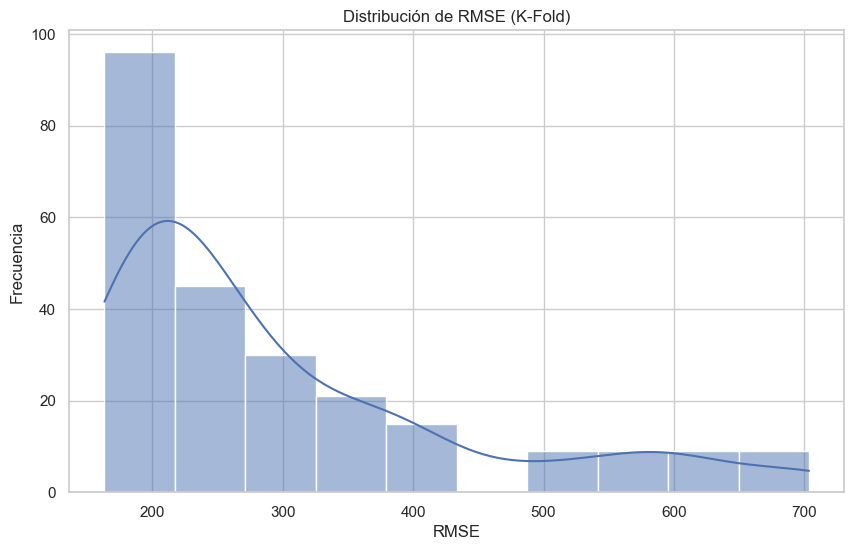

In [10]:
# Visualización: distribución de RMSE por modelos
sns.histplot(results_df["rmse"], kde=True)
plt.title("Distribución de RMSE (K-Fold)")
plt.xlabel("RMSE")
plt.ylabel("Frecuencia")
plt.show()

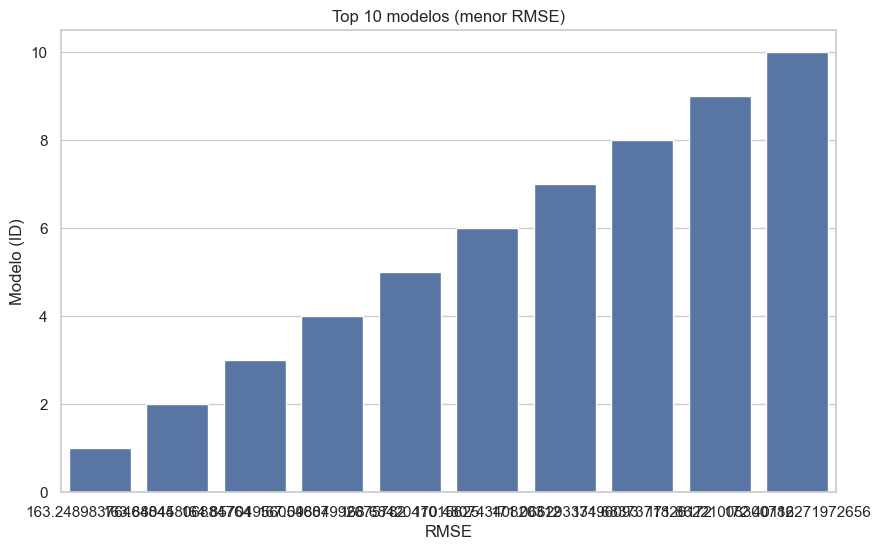

In [11]:
# Visualización: top 10 mejores modelos
sns.barplot(data=results_df.head(10), x="rmse", y="model_id")
plt.title("Top 10 modelos (menor RMSE)")
plt.xlabel("RMSE")
plt.ylabel("Modelo (ID)")
plt.show()


## Plot for each model (RMSE per combination)


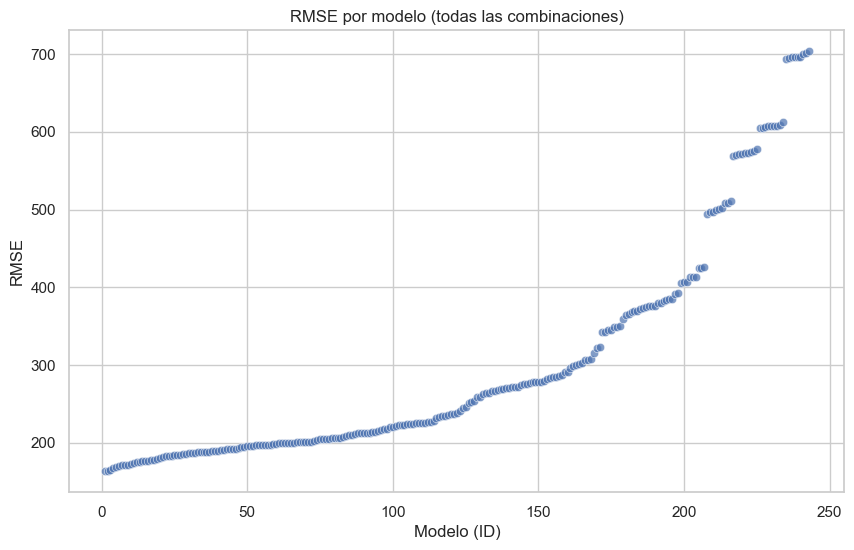

In [12]:
sns.scatterplot(data=results_df, x="model_id", y="rmse", alpha=0.7)
plt.title("RMSE por modelo (todas las combinaciones)")
plt.xlabel("Modelo (ID)")
plt.ylabel("RMSE")
plt.show()


## Metric comparison (each model)


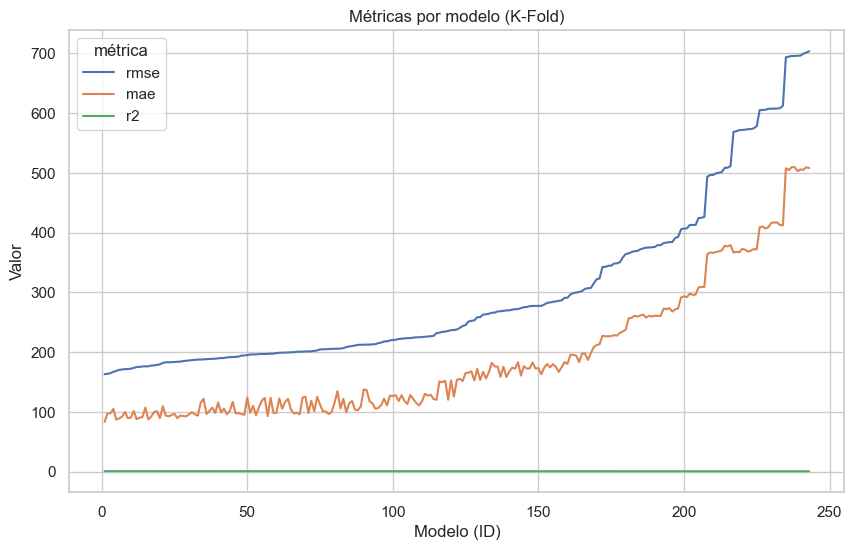

In [13]:
plot_df = results_df[["model_id", "rmse", "mae", "r2"]].melt(
    id_vars="model_id", var_name="métrica", value_name="valor"
)
sns.lineplot(data=plot_df, x="model_id", y="valor", hue="métrica")
plt.title("Métricas por modelo (K-Fold)")
plt.xlabel("Modelo (ID)")
plt.ylabel("Valor")
plt.show()


## Comparison with the previous best model
Manually insert the best Grid Search result here for comparison.


In [14]:
previous_best = {
    "model__colsample_bytree": 0.8,
    "model__learning_rate": 0.1,
    "model__max_depth": 3,
    "model__n_estimators": 800,
    "model__subsample": 0.8,
}

prev_pipe = make_pipeline(previous_best)
prev_cv = cross_validate(prev_pipe, X, y, cv=kfold, scoring=scoring, n_jobs=-1)

prev_rmse = -prev_cv["test_rmse"].mean()
prev_mae = -prev_cv["test_mae"].mean()
prev_r2 = prev_cv["test_r2"].mean()

print("Previous model (Grid Search):")
print(previous_best)
print(f"RMSE: {prev_rmse:.2f}")
print(f"MAE: {prev_mae:.2f}")
print(f"R2: {prev_r2:.2f}")

Previous model (Grid Search):
{'model__colsample_bytree': 0.8, 'model__learning_rate': 0.1, 'model__max_depth': 3, 'model__n_estimators': 800, 'model__subsample': 0.8}
RMSE: 164.86
MAE: 97.73
R2: 0.99


## Conclusions
- K-Fold provides a more stable performance estimate.
- The ranking helps select the most robust model.


## Save the best model
We save the model with the best hyperparameters found by K-Fold.


In [15]:
from sklearn.pipeline import Pipeline
import joblib

# Best parameters del GridSearch
print("Best parameters:", best_params)

# Extraer y CONVERTIR parámetros del modelo
best_model_params = {}
for k, v in best_params.items():
    if k.startswith("model__"):
        param_name = k.replace("model__", "")
        # Convertir a int si es necesario
        if param_name in ['n_estimators', 'max_depth', 'min_child_weight', 'max_delta_step']:
            best_model_params[param_name] = int(v)
        else:
            best_model_params[param_name] = v

print("Parámetros convertidos:", best_model_params)

# Crear modelo con mejores parámetros
best_xgb = XGBRegressor(**best_model_params, random_state=42)

# Crear pipeline completo
best_model = Pipeline([
    ('preprocessor', preprocessor),
    ('model', best_xgb)
])

# Entrenar con todos los datos
best_model.fit(X, y)

# Guardar
joblib.dump(best_model, "../best_xgb_model.pkl")
print("✅ Modelo guardado exitosamente")

Best parameters: {'model__colsample_bytree': 0.9, 'model__learning_rate': 0.1, 'model__max_depth': 6.0, 'model__n_estimators': 800.0, 'model__subsample': 0.8, 'rmse': 163.24898376464844, 'mae': 83.35094604492187, 'r2': 0.9900790810585022, 'model_id': 1.0}
Parámetros convertidos: {'colsample_bytree': 0.9, 'learning_rate': 0.1, 'max_depth': 6, 'n_estimators': 800, 'subsample': 0.8}
✅ Modelo guardado exitosamente


## Best model prediction plot


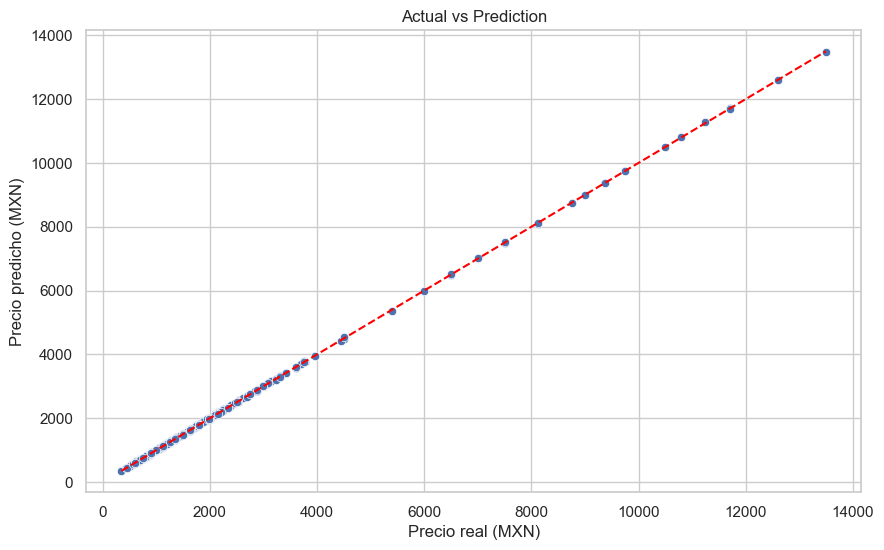

In [16]:
# Predicciones y comparación
preds_best = best_model.predict(X)
comparison = pd.DataFrame({
    "Real": y.values,
    "Predicción": preds_best
})

sns.scatterplot(data=comparison, x="Real", y="Predicción")
plt.plot([comparison["Real"].min(), comparison["Real"].max()],
         [comparison["Real"].min(), comparison["Real"].max()],
         color="red", linestyle="--")
plt.title("Actual vs Prediction")
plt.xlabel("Precio real (MXN)")
plt.ylabel("Precio predicho (MXN)")
plt.show()


## Final table: actual vs prediction and difference


In [17]:
# Mostrar todas las filas
pd.set_option('display.max_rows', None)

# Opcional: También ajustar columnas y ancho
pd.set_option('display.max_columns', None)
pd.set_option('display.width', None)

preds_final = best_model.predict(X)
comparison = pd.DataFrame({
    "Real": y.values,
    "Predicción": preds_final,
})
comparison["Diferencia"] = comparison["Predicción"] - comparison["Real"]

print(comparison)


      Real    Predicción  Diferencia
0     2000   1997.100464   -2.899536
1     2500   2507.522705    7.522705
2     3000   2998.650879   -1.349121
3     3600   3586.369629  -13.630371
4     1800   1802.390381    2.390381
5     2250   2243.093994   -6.906006
6     2700   2707.487061    7.487061
7     3240   3243.342285    3.342285
8     1400   1404.478027    4.478027
9     1750   1733.132690  -16.867310
10    2100   2098.566650   -1.433350
11    2520   2531.294434   11.294434
12    1500   1509.315430    9.315430
13    1875   1886.070190   11.070190
14    2250   2225.121094  -24.878906
15    2700   2697.340576   -2.659424
16    2200   2198.246338   -1.753662
17    2750   2750.585205    0.585205
18    3300   3334.629639   34.629639
19    3960   3937.931396  -22.068604
20    1900   1897.546021   -2.453979
21    2375   2384.333496    9.333496
22    2850   2853.316895    3.316895
23    3420   3417.727295   -2.272705
24    2500   2499.732910   -0.267090
25    3125   3122.231689   -2.768311
2

In [18]:
joblib.dump(best_model, "../best_xgb_model.pkl")

['../best_xgb_model.pkl']